In [1]:
import tensorflow
import keras
print('Keras      :', keras.__version__)
print('Tensorflow :', tensorflow.__version__)

Keras      : 2.2.4
Tensorflow : 1.12.0


Using TensorFlow backend.


In [2]:
!dir

 Datenträger in Laufwerk C: ist Local Disk
 Volumeseriennummer: 7078-18E5

 Verzeichnis von C:\Anaconda3\envs\tfk35\AAA_RobotVision

24.06.2019  13:21    <DIR>          .
24.06.2019  13:21    <DIR>          ..
20.06.2019  19:09    <DIR>          .ipynb_checkpoints
20.06.2019  18:04           265.172 Aufgabe_4_v2.ipynb
14.05.2019  18:48    <DIR>          Cat
24.06.2019  13:21           734.318 CIFAR100_Klassifikator.ipynb
14.05.2019  18:48    <DIR>          Dog
14.05.2019  19:32    <DIR>          keras_preprocessing
14.05.2019  19:50       154.243.960 mlp.h5
14.05.2019  19:50             2.548 mlp.pkl
14.05.2019  19:50        77.129.296 mlp_weights.h5
20.06.2019  19:08           414.739 MNIST_Klassifikator.ipynb
14.05.2019  17:03    <DIR>          models
20.06.2019  18:07               555 Untitled.ipynb
14.05.2019  19:29    <DIR>          ___keras-preprocessing-master
               7 Datei(en),    232.790.588 Bytes
               8 Verzeichnis(se), 689.435.111.424 Bytes frei


Nähere Einzelheiten finden Sie in der Keras Dokumentation. <br />
https://keras.io/





# Multiclass-Klassifikation 
## Zweck
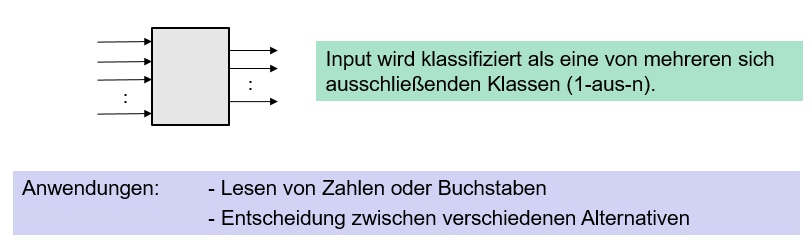

## Beispiel: Lesen handgeschriebener Zahlen 
### Idee
Im folgenden Beispiel sollen handgeschriebene Zahlen (Bildgröße 28x28) klassifiziert werden.
### Daten
Die Daten für das Training und die Validation des Klassifikators, stammen aus dem MNIST-Dataset.  
Die Daten sind wie folgt aufgeteilt: 60.000 Trainingsdaten und 10.000 Testdaten.  
Der MNIST-Datensatz ist im Keras-Paket enthalten.

---



# Es geht los ......
### Laden der benötigten Python-Bibliotheken
<ul>
<li><strong>numpy</strong>: Wissenschaftliches Rechnen mit Python
<li><strong>keras</strong>: Zusatz zu Tensorflow. Die Erstellung und das Training Neuronaler Netze wird dadurch erheblich vereinfacht.
<lu>

In [3]:
# Biliothek: Drucken von Grafiken, Bildern, etc. .....
from matplotlib            import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# Bibliothek: Rechnen mit Matrizen, Vektoren, etc. ......
import numpy as np
import keras

from keras                 import backend as K
from keras.models          import Sequential
from keras.datasets        import mnist
from keras.layers          import Dense, Activation, Dropout, Flatten
from keras.utils           import np_utils
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.optimizers      import RMSprop

### Reproduzierbare Versuche
Zufallszahlengenerator (z.B. bei der Initialisierung von NN) immer gleich starten (mit seed()).<br />
Die Neuronengewichte werden auf diese Weise immer mit den gleichen Zufallszahlen initialisiert. <br />
Versuche werden dadurch wiederholbar und vergleichbar.

In [4]:
np.random.seed(13)

### MNIST-Datensatz für Training und Test laden

In [5]:
(X_train_ori, y_train_ori), (X_test_ori, y_test_ori) = mnist.load_data()   # MNIST-Datensatz laden

NumClasses         = 10                    # Anzahl der Klassen (MNIST)
ImgRows, ImgCols   = 28, 28                # Format des Input-Fensters (MNIST)
InputSize          = ImgRows * ImgCols     # Größe des Input-Fensters (MNIST)

In [6]:
print('X_train_ori :', X_train_ori.shape)
print('X_test_ori  :', X_test_ori.shape)

X_train_ori : (60000, 28, 28)
X_test_ori  : (10000, 28, 28)


# ============================================================

# Versuch 1: Multilayer-Perzeptron mit einem hidden Layer

### Formatierung der Trainings- und Testdaten für das Multilayer-Perzeptron
Multilayer-Perzeptron bekommt kein 28x28-Bild, sondern einfach nur 784 Inputwerte (= InputSize).

In [7]:
X_train = X_train_ori.reshape(60000, InputSize)
X_test  = X_test_ori.reshape( 10000, InputSize)

In [8]:
print('X_train :', X_train.shape)
print('X_test  :', X_test.shape)

X_train : (60000, 784)
X_test  : (10000, 784)


In [9]:
#  Funktionsdeklaration : Bilder in einem Raster Drucken
def draw_digit(data, row, col, n):
    plt.subplot(row, col, n)    
    plt.imshow(data)
    plt.gray()

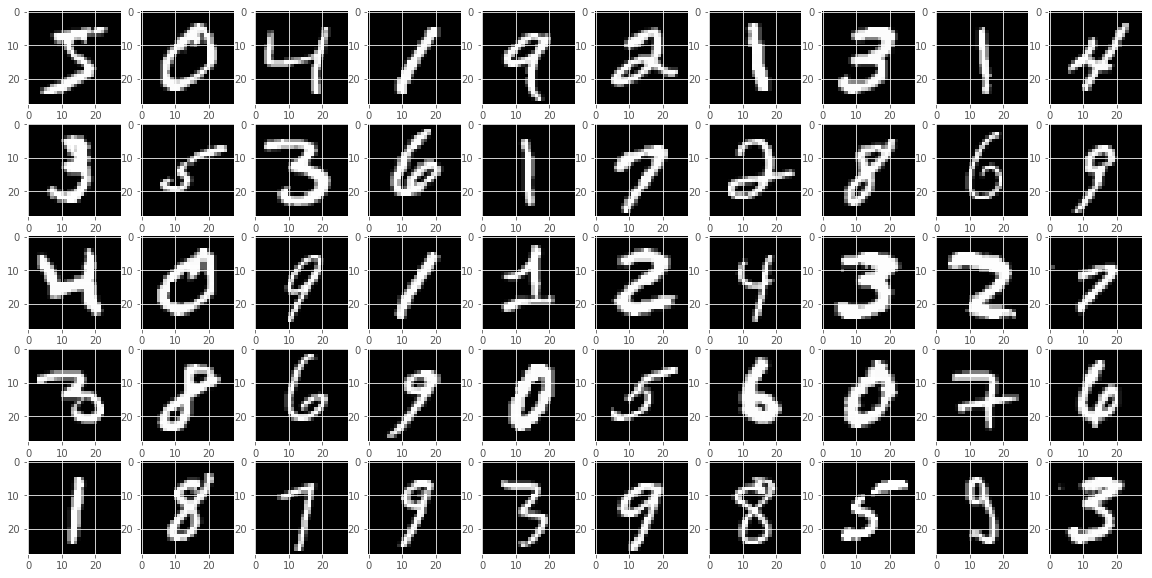

In [10]:
# Eine Auswahl von handgeschriebenen Zeichen in einem Bildraster anzeigen
cols                = 10
rows                = 5
plt.figure(figsize  = (20,10))

for i in range(rows):
    for k in range(cols):
        draw_digit(X_train[i*10+k].reshape(28,28), rows, cols, i*10+k+1)

plt.show()

### Grauwerte der Bilder für das NN aufbereiten

In [11]:
# Bildpunkttyp (Grauwerte = 0 ...255) auf float konvertieren ....
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# ... und auf den Wertebereich 0...1 transformieren
X_train /= 255
X_test  /= 255

#X_train = X_train/255 -0.5;
#X_test  = X_test /255 -0.5;

print('X_train :', X_train.shape)
print('X_test  :', X_test.shape)

X_train : (60000, 784)
X_test  : (10000, 784)


### Ergebnisse der Trainings- und Testdaten aufbereiten

Die Ergebnisse (Klassen der Bilder) liegen im Datensatz als Integerzahl vor (z.B. 7) wenn eine 7 abgebildet ist.<br />
Benötigt werden aber die Outputs des NN, also z.B. [0 0 0 0 0 0 0 1 0 0] für die abgebildete 7 (= One-hot-Encoding). 

Zu diesem Zweck müssen die Outputklassen konvertiert werden.

In [12]:
print(y_train_ori.shape)
print(y_train_ori[:5])

(60000,)
[5 0 4 1 9]


In [13]:
# Zahlenwert der Outputklasse konvertieren in 10-dim. Outputvektor transformieren (to_categorical-Methode)
Y_train = np_utils.to_categorical(y_train_ori, 10)
Y_test  = np_utils.to_categorical(y_test_ori,  10)

print(Y_train.shape)
print()
print(y_train_ori[:5])
print()
print(Y_train[:5])

(60000, 10)

[5 0 4 1 9]

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### Beschreibung des gewünschten Neuronalen Netzes
Mit model.add() wird Schicht für Schicht des NN beschrieben.
<ul>
<li><strong>Dense</strong>: Einfacher Fully-connected-Layer.
<li><strong>sigmoid</strong>: Logistische Aktivierrungsfunktion (Alternativen: tanh, relu, ....).
<li><strong>glorot_uniform</strong>: Methode zur zufälligen Gewichtsinitialisierung.
</ul>

Der Outputlayer ist als *Softmax-Layer* ausgelegt. Die Summe der Ausgabewerte ist somit 1. <br />
Der *Softmax-output-Layer* wird immer in Verbindung mit dem *Categorical_crossentropy-Fehlermaß* verwendet!

In [22]:
# ----------------------------------------------------
# Netz 1: - Multilayer-Perzeptron mit einem Hidden-Layer
#         - Logistische Aktivierungsfunktion
# ----------------------------------------------------


# ------------------------------------------------------------------------------------------
# Beschreibung des Netzes, Layer für Layer.
# ------------------------------------------------------------------------------------------
model = Sequential()

# 1. Hidden Layer:  Fully connected mit ReLu-Aktivierungsfunktion
model.add(Dense(units = 50,   kernel_initializer="glorot_uniform",   input_shape=(InputSize,)))
model.add(Activation("sigmoid"))


# Output Layer:  Fully connected mit Softmax-Aktivierungsfunktion
model.add(Dense(NumClasses,  kernel_initializer="glorot_uniform"))
model.add(Activation('softmax'))

# ------------------------------------------------------------------------------------------

In [23]:
# Übersicht über das NN und die Parameter
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                39250     
_________________________________________________________________
activation_3 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
activation_4 (Activation)    (None, 10)                0         
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________


### Konfiguration des Lernprozesses
Gute Erklärungen zu den Parametern sind hier zu finden:  ([link](http://ruder.io/optimizing-gradient-descent/index.html#rmsprop))

In [24]:
model.compile(loss      = 'categorical_crossentropy',     # categorical_crossentropy, mse
              optimizer = 'rmsprop',     # sgd, adam, rmsprop
              metrics   = ['accuracy'])

### Training des NN

In [25]:
# Training
history = model.fit(X_train, Y_train,
                  batch_size      =  32,    # Minibatch-Größe
                  epochs          =  10,    # Anzahl der Trainingsepochen (ohne GPU nicht übertreiben)
                  verbose         =  1,     # Informationen anzeigen
                  validation_data =  (X_test, Y_test))


score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 129us/step - loss: 0.4633 - acc: 0.8866 - val_loss: 0.2470 - val_acc: 0.9284
Epoch 2/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.2246 - acc: 0.9353 - val_loss: 0.1992 - val_acc: 0.9414
Epoch 3/10
60000/60000 [==============================] - 7s 125us/step - loss: 0.1840 - acc: 0.9463 - val_loss: 0.1746 - val_acc: 0.9480
Epoch 4/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.1597 - acc: 0.9535 - val_loss: 0.1577 - val_acc: 0.9538
Epoch 5/10
60000/60000 [==============================] - 7s 123us/step - loss: 0.1425 - acc: 0.9578 - val_loss: 0.1466 - val_acc: 0.9574
Epoch 6/10
60000/60000 [==============================] - 9s 145us/step - loss: 0.1295 - acc: 0.9625 - val_loss: 0.1367 - val_acc: 0.9595
Epoch 7/10
60000/60000 [==============================] - 9s 149us/step - loss: 0.1191 - acc: 0.9653 - val_loss: 0.1301 - 

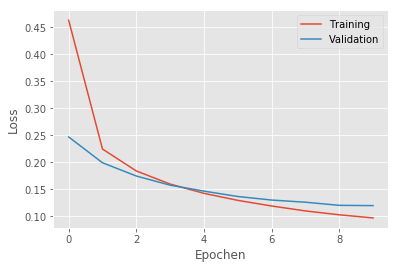

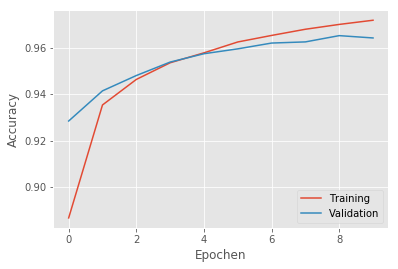

In [26]:
plt.figure(0)

plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(1)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

============================================================================================================
# !!! Aufgaben

a) Berechnen Sie selber die Anzahl der Parameter.

b) Modifizieren Sie das NN und das Trainingsverfahren [z.B. Anzahl der Neuronen, Hidden-layer-Aktivierungsfunktionen: (sigmoid, tanh, relu), Optimizer (sgd, adam, rmsprop), Batchsize (3, 30, 300), Anzahl der Trainingsepochen, ...] mit dem Ziel, eine Validation-Accuracy von ** ca 98% ** zu erreichen.  

**Wichtig:** Die Zahl der Layer soll dabei nicht erhöht werden. 

### Dokumentieren Sie mind. 3 Versuchsvarianten 
* Parameter 
* Val.-Accuracy 
* graph. Traingsverläufe
* Trainingszeit

============================================================================================================

### Fehleranalyse
1. Anzeigen einiger Fehlklassifikationen
2. Confusion-Matrix (= wer wird mit wem verwechselt?)

In [27]:
# Die erkannten Klassen der Testdaten bestimmen.
predicted_classes = model.predict_classes(X_test)

# Die Indices der richtig und falsch erkannten Muster bestimmen
correct   = np.nonzero(predicted_classes == y_test_ori)[0]     # nonzero:  Return the indices of array-
incorrect = np.nonzero(predicted_classes != y_test_ori)[0]     #           elements that are non-zero

<Figure size 432x288 with 0 Axes>

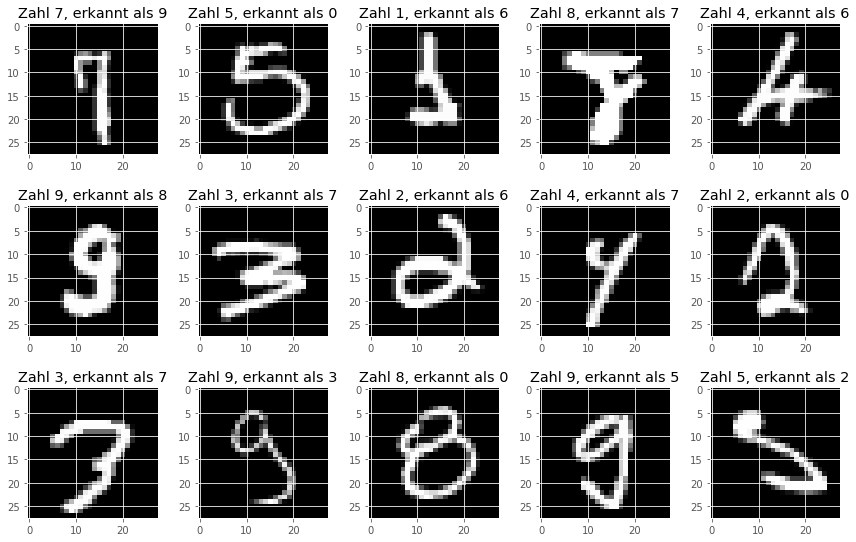

In [28]:
start                = 60    # Startindex

plt.figure(2)
plt.figure(figsize   = (12,8))
           
for i, incorr in enumerate(incorrect[start:start+15]):
    #print(i, incorr)
    plt.subplot(3,5,i+1)
    plt.imshow(X_test[incorr].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Zahl {}, erkannt als {}".format(y_test_ori[incorr], predicted_classes[incorr]))
    plt.tight_layout()

In [29]:
# Die Confusion-Matrix zeigt an, wie oft ein Zeichen
# für ein anderes Zeichen gehalten wird.
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_ori, predicted_classes))

[[ 969    0    2    1    1    1    3    2    1    0]
 [   0 1113    5    1    0    1    4    3    8    0]
 [   7    0  998    2    6    0    4    6    9    0]
 [   1    0    8  961    0   13    1   13    6    7]
 [   2    0    3    1  949    0    5    4    2   16]
 [   6    1    2   10    3  852    6    2    7    3]
 [  11    2    0    1    4    5  929    0    6    0]
 [   0    5   16    7    1    1    0  991    1    6]
 [   8    2    4    9    8    7    4    9  920    3]
 [   5    3    1    6   16    7    0    9    2  960]]


# ==============================================================

# Versuch 2: Multilayer-Perzeptron erweitert

In [30]:
# -------------------------------------------------
# Netz 2: - Multilayer-Perzeptron mit 2 (oder mehr) Hidden-Layern
#         - ReLu-Aktivierungsfunktion
#         - Dropout-Layer
# -------------------------------------------------


# ------------------------------------------------------------------------------------------
# Beschreibung des Netzes, Layer für Layer.
# ------------------------------------------------------------------------------------------
model = Sequential()

model.add(Dense(units = 300,  kernel_initializer="glorot_uniform", input_shape=(InputSize,)))
model.add(Activation('tanh'))

#model.add(Dropout(0.3))

model.add(Dense(units = 150, kernel_initializer="glorot_uniform"))
model.add(Activation('tanh'))

#model.add(Dropout(0.3))

model.add(Dense(NumClasses, kernel_initializer="glorot_uniform"))   # Der letzte Layer hat ein Output pro Klasse.
model.add(Activation('softmax')) 
 
    
    
# Übersicht über das NN und die Parameter
model.summary()
  
    
    
# Konfiguration des Trainings
model.compile(loss     ='categorical_crossentropy', 
              optimizer='sgd',                 # sgd, rmsprop, adam 
              metrics  =["accuracy"])
 
    
    
# Durchführung des Trainings
hist2= model.fit(X_train, Y_train,
                batch_size = 30,               # 3, 30, 300 
                epochs     = 10, 
                verbose    = 1,
                validation_data = (X_test, Y_test))



# Endergebnis berechnen und ausgeben
score = model.evaluate(X_test, Y_test, verbose=0)
print()
print('Test score:   ', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 300)               235500    
_________________________________________________________________
activation_5 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 150)               45150     
_________________________________________________________________
activation_6 (Activation)    (None, 150)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1510      
_________________________________________________________________
activation_7 (Activation)    (None, 10)                0         
Total params: 282,160
Trainable params: 282,160
Non-trainable params: 0
_________________________________________________________________
Trai

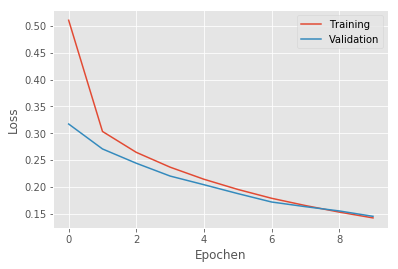

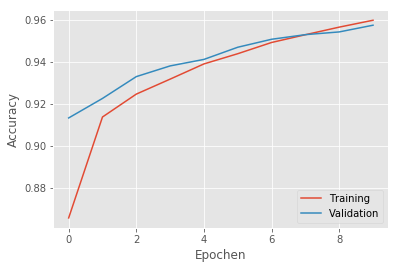

In [31]:
plt.figure(3)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(4)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist2.history['acc'])
plt.plot(hist2.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

============================================================================================================
# !!! Aufgaben

a) Berechnen Sie selber die Anzahl der Parameter.

b) Modifizieren Sie das NN und das Trainingsverfahren [z.B. Anzahl der Neuronen, Anzahl der Layer, Hidden-layer-Aktivierungsfunktionen: (sigmoid, tanh, relu), Optimizer (sgd, adam, rmsprop), Batchsize (3, 30, 300), Anzahl der Trainingsepochen, ...] mit dem Ziel, eine Validation-Accuracy von **>98%** zu erreichen.   
 

### Dokumentieren Sie mind. 3 Versuchsvarianten 
* Parameter 
* Val.-Accuracy 
* graph. Traingsverläufe
* Trainingszeit

============================================================================================================

### Fehleranalyse
1. Anzeigen einiger Fehlklassifikationen
2. Confusion-Matrix (= wer wird mit wem verwechselt?)

In [32]:
# Die erkannten Klassen der Testdaten bestimmen.
predicted_classes = model.predict_classes(X_test)

# Die Indices der richtig und falsch erkannten Muster bestimmen
correct   = np.nonzero(predicted_classes == y_test_ori)[0]     # nonzero:  Return the indices of array-
incorrect = np.nonzero(predicted_classes != y_test_ori)[0]     #           elements that are non-zero

<Figure size 432x288 with 0 Axes>

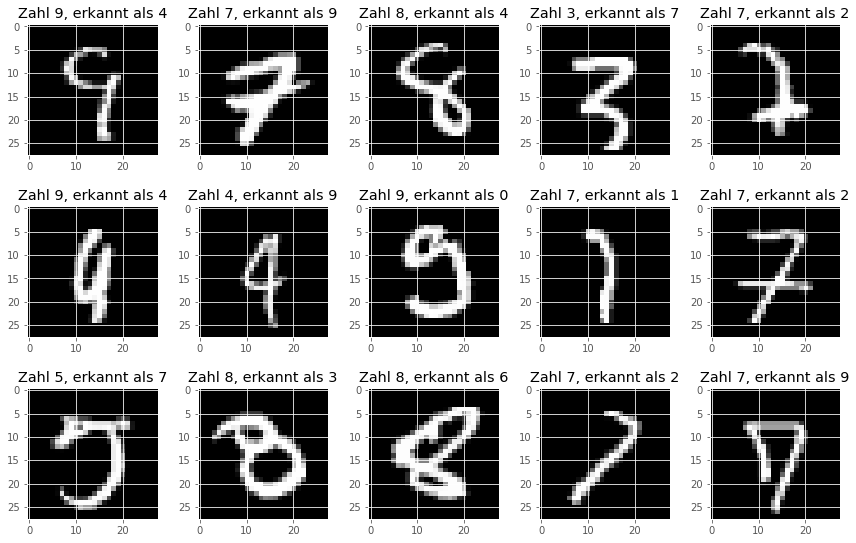

In [33]:
start                = 60    # Startindex

plt.figure(5)
plt.figure(figsize   = (12,8))
           
for i, incorr in enumerate(incorrect[start:start+15]):
    #print(i, incorr)
    plt.subplot(3,5,i+1)
    plt.imshow(X_test[incorr].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Zahl {}, erkannt als {}".format(y_test_ori[incorr], predicted_classes[incorr]))
    plt.tight_layout()

In [34]:
# Die Confusion-Matrix zeigt an, wie oft ein Zeichen
# für ein anderes Zeichen gehalten wird.
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_ori, predicted_classes))

[[ 964    0    1    2    0    4    7    1    1    0]
 [   0 1124    2    1    0    1    4    2    1    0]
 [   7    1  984    4    7    0    9    8   10    2]
 [   1    1    8  964    0   14    0   10    9    3]
 [   1    0    5    1  945    0    9    4    2   15]
 [   8    2    0   12    2  845   10    2    7    4]
 [   8    3    1    0    6   11  927    0    2    0]
 [   1    6   15    3    7    0    0  979    1   16]
 [   4    4    3    9    9   11   10   11  909    4]
 [   6    7    1    7   32    6    1   11    5  933]]


# ==============================================================

# Versuch 3: Kleines Faltungsnetzwerk (CNN)

### Einige zusätzliche Bibliotheken werden benötigt.

In [50]:
from keras.layers.convolutional import Conv2D
from keras.layers.pooling       import MaxPooling2D
from keras.layers               import BatchNormalization
from keras.utils                import np_utils
from keras.optimizers           import SGD

### Für Faltungsnetzwerke müssen die Bilddaten etwas anders aufbereitet werden (2-dimensional).

In [36]:
if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (ImgRows, ImgRows, 1)
    
print(shape_ord)

(28, 28, 1)


In [37]:
# ....
X_train = X_train_ori.reshape((X_train.shape[0],) + shape_ord)
X_test  = X_test_ori.reshape((X_test.shape[0],)   + shape_ord)

# Bildpunkttyp auf float konvertieren ....
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# ... und auf Wertebereich 0...1 transformieren
X_train /= 255
X_test  /= 255

print('X_train :', X_train.shape)
print('X_test  :', X_test.shape)

X_train : (60000, 28, 28, 1)
X_test  : (10000, 28, 28, 1)


In [53]:
# ------------------------------------------------------------
# Netz 3: - Convolutional_NN mit 3 Conv-Layern + 2 Dense-Layern
#         - ReLu-Aktivierungsfunktion
#         - Dropout-Layer
# ------------------------------------------------------------

model = Sequential()

# -----------------------------------------------------------------------------------------
# Feature-Extractor
# -----------------------------------------------------------------------------------------
model.add(Conv2D(filters=32,      
                 kernel_size=(3, 3),   # (5, 5)
                 padding='valid', 
                 input_shape = shape_ord))
model.add(Activation('tanh'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(BatchNormalization())

model.add(Dropout(0.2))


model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(BatchNormalization())

model.add(Dropout(0.2))


model.add(Conv2D(filters=128, kernel_size=(3, 3)))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(BatchNormalization())

model.add(Dropout(0.2))

    
model.add(Flatten())

# -----------------------------------------------------------------------------------------
# Classifier
# -----------------------------------------------------------------------------------------

model.add(Dense(units=128))
model.add(Activation('tanh'))

#model.add(BatchNormalization())

model.add(Dropout(0.4))

model.add(Dense(units=10))
model.add(Activation('softmax'))

In [42]:
# Übersicht über das Faltungsnetzwerk und die Parameter
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_13 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
activation_14 (Activation)   (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 64)        0         
__________

In [43]:
model.compile(loss     =  'categorical_crossentropy',
              optimizer=  'sgd',         # sgd, rmsprop, adam
              metrics  =  ['accuracy'])



hist3 = model.fit(X_train, Y_train, 
                  batch_size = 30,        # 3, 30, 300
                  epochs     = 10,        
                  verbose    = 1,
                  validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 28s 465us/step - loss: 0.5587 - acc: 0.8254 - val_loss: 0.1727 - val_acc: 0.9469
Epoch 2/10
60000/60000 [==============================] - 24s 393us/step - loss: 0.2095 - acc: 0.9366 - val_loss: 0.0977 - val_acc: 0.9696
Epoch 3/10
60000/60000 [==============================] - 25s 424us/step - loss: 0.1484 - acc: 0.9550 - val_loss: 0.0737 - val_acc: 0.9766
Epoch 4/10
60000/60000 [==============================] - 25s 423us/step - loss: 0.1173 - acc: 0.9645 - val_loss: 0.0591 - val_acc: 0.9802
Epoch 5/10
60000/60000 [==============================] - 30s 492us/step - loss: 0.0987 - acc: 0.9704 - val_loss: 0.0508 - val_acc: 0.9832
Epoch 6/10
60000/60000 [==============================] - 35s 589us/step - loss: 0.0883 - acc: 0.9729 - val_loss: 0.0462 - val_acc: 0.9848
Epoch 7/10
60000/60000 [==============================] - 78s 1ms/step - loss: 0.0817 - acc: 0.9754 - val_loss: 0.04

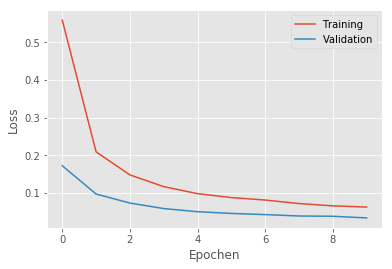

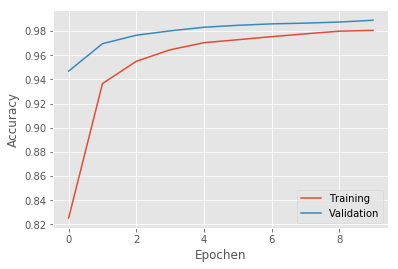

In [44]:
plt.figure(6)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(7)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist3.history['acc'])
plt.plot(hist3.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

============================================================================================================
# !!! Aufgaben

a) Berechnen Sie selber die Anzahl der Parameter.

b) Modifizieren Sie das NN und das Trainingsverfahren [z.B. Anzahl der Neuronen, Anzahl der Layer, Hidden-layer-Aktivierungsfunktionen: (sigmoid, tanh, relu), Optimizer (sgd, adam, rmsprop), BatchNormalization, Batchsize (3, 30, 300), Anzahl der Trainingsepochen, ...] mit dem Ziel, eine Validation-Accuracy von **ca. 99.5%** zu erreichen.    
 

### Dokumentieren Sie mind. 3 Versuchsvarianten 
* Parameter 
* Val.-Accuracy 
* graph. Traingsverläufe
* Trainingszeit

============================================================================================================

### Fehleranalyse
1. Anzeigen einiger Fehlklassifikationen
2. Confusion-Matrix (= wer wird mit wem verwechselt?)

In [45]:
# Die erkannten Klassen der Testdaten bestimmen.
predicted_classes = model.predict_classes(X_test)

# Die Indices der richtig und falsch erkannten Muster bestimmen
correct   = np.nonzero(predicted_classes == y_test_ori)[0]     # nonzero:  Return the indices of array-
incorrect = np.nonzero(predicted_classes != y_test_ori)[0]     #           elements that are non-zero ()

In [46]:
# predicted_classes[40:45]
# y_test_ori[40:45]
# np.nonzero(predicted_classes == y_test_ori)[0].shape
np.nonzero(predicted_classes != y_test_ori)[0].size

110

<Figure size 432x288 with 0 Axes>

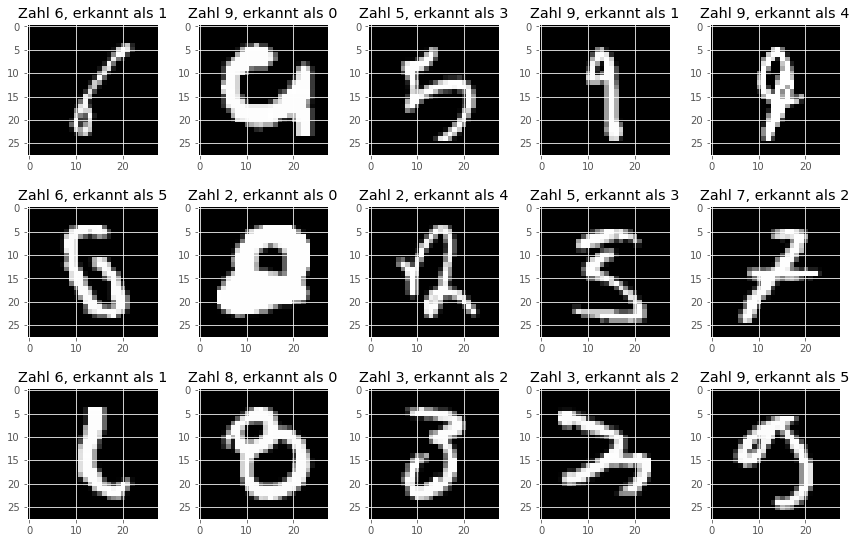

In [47]:
start                = 40    # Startindex

plt.figure(8)
plt.figure(figsize   = (12,8))
           
for i, incorr in enumerate(incorrect[start:start+15]):
    #print(i, incorr)
    plt.subplot(3,5,i+1)
    plt.imshow(X_test[incorr].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Zahl {}, erkannt als {}".format(y_test_ori[incorr], predicted_classes[incorr]))
    plt.tight_layout()

In [48]:
# Die Confusion-Matrix zeigt an, wie oft ein Zeichen
# für ein anderes Zeichen gehalten wird.
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_ori, predicted_classes))

[[ 976    0    1    0    0    1    1    1    0    0]
 [   0 1130    1    0    0    0    2    1    1    0]
 [   2    2 1022    1    1    0    0    4    0    0]
 [   0    0    2 1000    0    3    0    3    1    1]
 [   0    0    1    0  974    0    4    0    0    3]
 [   2    0    0    5    0  882    1    1    1    0]
 [   6    2    0    0    1    5  944    0    0    0]
 [   0    2    7    1    0    0    0 1016    1    1]
 [   4    0    2    3    1    1    1    2  956    4]
 [   1    3    0    4    4    3    0    3    1  990]]
